<a href="https://colab.research.google.com/github/tony-wade/Qiskit/blob/main/Quantum%20Relation%20Network%20/QRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

QRN - 10 way 1 shot learning(FSL)

歡迎先看此處的說明: https://wadewu.odoo.com/blog/coding-3/ren-ren-du-neng-you-ge-xiao-mo-xu-luo-12

I don't recommend using TorchConnector's backward with this model, as it has a performance issue.So, instead of following the normal training process, I have opted to initially train a regular CNN with the training data. Later, I will integrate it with the QRN and evaluate the combined model.

Besides that, I think QRN did a nice job on training-free classification and flexibility, and has the potential to be used in meta-learning.

In [1]:
import os
import random
import itertools
import numpy as np
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
from torch import Tensor
import torch.nn as nn
import torch
from torch import no_grad
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
#!pip install qiskit
!pip install qiskit-machine-learning
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_tensor_type('torch.FloatTensor')

In [3]:
# 定義數據增強
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.15,0.15), shear=(7,7)),  # 隨機平移、推移
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.85, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


class CustomMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_name).convert('L')  # 轉成黑白
        image = ImageOps.invert(img)
        label = int(self.image_files[idx].split('.')[0])  # 文件名=tag

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
n_classes = 10    # 類別數
batch_size = 20
num_copies = 20  # 數據增強倍率（每個類別的複製數）
n_sup = 1   # 每類別用於測量的data數
n_test = 20   # 每類別用於測試的data數

# Sample  set
#
# Sample: 28*28 10 pics(1-shot)
sample = CustomMNISTDataset('./selfmnist', transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                      ]))

# Train(Query)：by data aug.
train = []
for _ in range(num_copies):
    augmented_dataset = CustomMNISTDataset('./selfmnist', transform=transform)
    train.append(augmented_dataset)

train = ConcatDataset(train)


# Support set
#
# 從每個類別中隨機選取n_sup個樣本
X_sup = datasets.MNIST(root='./data', train=True, transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                          ]), download=True)
idx = []
for digit in range(n_classes):
        digit_indices = np.where(X_sup.targets == digit)[0]
        selected_indices = random.sample(digit_indices.tolist(), n_sup)
        idx.extend(selected_indices)
X_sup.data = X_sup.data[idx]
X_sup.targets = X_sup.targets[idx]



# Test set
#
X_test = datasets.MNIST(root='./data', train=False, transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                           ]), download=True)
idx = []
for digit in range(n_classes):
    digit_indices = np.where(X_test.targets == digit)[0]
    selected_indices = random.sample(digit_indices.tolist(), n_test)
    idx.extend(selected_indices)

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]


# 定義dataloader
#
sample_loader = DataLoader(sample, batch_size=1, shuffle=True)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
sup_loader = DataLoader(X_sup, batch_size=1, shuffle=False)
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)

In [5]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1, 16, kernel_size=3, bias=False),     # 拆成兩組3*3kernel會比一個5*5精細,接BN則不需bias
                        nn.BatchNorm2d(16, momentum=1, affine=True),    # 縮放/歸一 加速訓練 減少Ocerfitting
                        nn.ReLU(),
                        nn.Conv2d(16, 32, kernel_size=3, bias=False),
                        nn.BatchNorm2d(32, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.Conv2d(32, 32, kernel_size=5, padding=1, bias=False),
                        nn.BatchNorm2d(32, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Dropout2d(p=0.4))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(32, 64, kernel_size=3, bias=False),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.Conv2d(64, 64, kernel_size=3, bias=False),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.Conv2d(64, 64, kernel_size=5, padding=1, bias=False),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Dropout2d(p=0.4))
        self.layer3 = nn.Sequential(
                        nn.Conv2d(64, 64, kernel_size=2, bias=False),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.Conv2d(64, 32, kernel_size=1)
                        )

    def forward(self,x):
        out = self.layer1(x)      # ((28-3+1-3+1)+2*1-5+1)/2 +1= 11*11
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)    # batch,32
        return out

In [6]:
class NN_Trainonly(nn.Module):

  def __init__(self):
    super(NN_Trainonly, self).__init__()
    self.fc1 = nn.Sequential(
                   nn.Linear(32, 10),
                )

  def forward(self, x):
    out = self.fc1(x)
    return out

# initialize nn
def init_weights(m):
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.02)
        m.bias.data.zero_()

In [7]:
# 超過12 qubits的circuit會計算很久
num_qubits = 8
reps = 1
circuit = EfficientSU2(num_qubits=num_qubits, entanglement='sca', reps=reps, flatten=True)   # 共2*qubit數*(reps+1)個input
print("parameters in encoder:",circuit.num_parameters)


class QuantumRelationNetwork(nn.Module):
    def __init__(self, num_qubits, reps):
        super(QuantumRelationNetwork, self).__init__()

        # 必須重複，否則默認inverse為展示的前者反向(),非一circuit；它會連同input次序也相反
        encoder = EfficientSU2(num_qubits=num_qubits, entanglement='sca', parameter_prefix='a', reps=reps, flatten=True)
        inverse_encoder =  EfficientSU2(num_qubits=num_qubits, entanglement='sca', reps=reps, parameter_prefix='b', flatten=True).inverse()
        qc = QuantumCircuit(num_qubits)
        qc.compose(encoder, qubits=range(num_qubits) , inplace=True)
        qc.compose(inverse_encoder, qubits=range(num_qubits) , inplace=True)

        # Default: measure Z...=|0....0>, output:-1~1
        QRN = EstimatorQNN(
                    circuit=qc,
                    input_params=qc.parameters,
                    input_gradients=True
                    )
        self.Qnn = TorchConnector(QRN)

    def forward(self, input_data):
        out = self.Qnn.forward(input_data)
        return out

parameters in encoder: 32


Alternative

```
# 自製的interpret func.,能區分全|0>=last_bit為|1>與其他states的機率
#
# 轉成000..10的形式，分出|0>較多者
def interpret(x):
    bit = format(x, '010b')
    return int(bit.count("0") > bit.count("1"))

output_shape = 2
.
.
        self.Qnn = SamplerQNN(
                    circuit=qc,
                    input_params=encoder.parameters,
                    weight_params=inverse_encoder.parameters,
                    interpret=interpret,
                    output_shape=output_shape,
                    input_gradients=True
                    )
```



In [8]:
# Define optimizer, and loss function. Where every fidelity is a posibility i.e. is a multi-label binary class classification
lr = 0.001
b1 = 0.4
b2 = 0.7

extract = CNN().to(device)
classifier = NN_Trainonly().to(device)
QRN =  QuantumRelationNetwork(num_qubits, reps).to(device)
optimizer = optim.NAdam(extract.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.0005)
opt_train = optim.NAdam(classifier.parameters(), lr=lr*4, weight_decay=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss_func = nn.BCEWithLogitsLoss()

After a few experiences, I have discovered that the structure of a QRN can somewhat influence its performance. This is due to multiple features affecting a single qubit. If we choose to encode each feature on a single qubit using a PauliFeatureMap, it will exceed the GPU usage limit in Colab within a second or so. Therefore, we can attempt to improve performance by either rearranging the input parameters' order during training or by investing in a larger GPU capacity.

In [9]:
# Setting
epochs = 100
loss_list = []
global_loss_list = []
acc_list = []

# Set desired output
target = torch.ones(batch_size).to(device)

for epoch in range(epochs):
    # Support set
    #
    # 從每個類別中隨機選取n_sup個樣本
    X_sup = datasets.MNIST(root='./data', train=True, transform=transforms.Compose([
                                              transforms.ToTensor(),
                                              transforms.Normalize((0.5,), (0.5,))
                                              ]), download=True)
    idx = []
    for digit in range(n_classes):
        digit_indices = np.where(X_sup.targets == digit)[0]
        selected_indices = random.sample(digit_indices.tolist(), n_sup)
        idx.extend(selected_indices)
    X_sup.data = X_sup.data[idx]
    X_sup.targets = X_sup.targets[idx]
    sup_loader = DataLoader(X_sup, batch_size=1, shuffle=True)



    # Initialize every epochs
    total_loss = []
    global_loss = []
    correct = 0


    """


    extract.train()
    for _, (data, label_batch) in enumerate(train_loader):
        # Initialize performance
        output = torch.zeros(batch_size, n_classes)
        one_hot_target = torch.zeros(batch_size, n_classes)
        for i, label in enumerate(label_batch):
            one_hot_target[i, label] = 1
        one_hot_target = one_hot_target.to(device)

        # Doesn't support batch operation with different weight
        feature_trains = extract(data.to(device))

        for idx in range(batch_size):
          # Initialize performance for this sample
          sample_output = torch.zeros(n_classes)
          for _ , (image, label) in enumerate(sample_loader):
              feature_sample = extract(image.to(device))
              features = torch.cat((feature_sample, feature_trains[idx,:].unsqueeze(0)), dim=1)
              value = QRN.forward(features)
              sample_output[label] = value[0, 0]

          output[idx] = sample_output

        output = output.to(device)

        loss = loss_func(output, one_hot_target)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(extract.parameters(),0.5)
        optimizer.step()
        total_loss.append(loss.item())
    """

    # Train
    extract.train()
    for _, (data, label_batch) in enumerate(train_loader):


        # Initial output
        one_hot_target = torch.zeros(len(label_batch), n_classes)
        for i, label in enumerate(label_batch):
            one_hot_target[i, label] = 1
        one_hot_target = one_hot_target.to(device)

        feature_train = extract(data.to(device))
        output = classifier(feature_train)
        loss = loss_func(output, one_hot_target)
        optimizer.zero_grad(set_to_none=True)
        opt_train.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm(extract.parameters(),0.5)
        torch.nn.utils.clip_grad_norm(classifier.parameters(),0.5)
        opt_train.step()
        optimizer.step()
        total_loss.append(loss.item())



    # Examine model's performance
    extract.eval()
    for _, (data, label_batch) in enumerate(train_loader):
        # Initialize performance
        output = torch.zeros(batch_size, n_classes)
        one_hot_target = torch.zeros(batch_size, n_classes)
        for i, label in enumerate(label_batch):
            one_hot_target[i, label] = 1
        one_hot_target = one_hot_target.to(device)

        # Doesn't support batch operation with different weight
        features = extract(data.to(device))

        for idx in range(batch_size):
          # Initialize performance for this sample
          single_output = torch.zeros(n_classes)
          for _ , (image, label) in enumerate(sample_loader):
              feature_sup = extract(image.to(device))
              feature_cat = torch.cat((feature_sup, features[idx,:].unsqueeze(0)), dim=1)
              value = QRN.forward(feature_cat)
              single_output[label] = value[0, 0]

          output[idx] = single_output

        output = output.to(device)
        label_batch = label_batch.to(device)
        pred = torch.argmax(output, dim=1)
        score = (pred == label_batch).float()
        correct += (pred == label_batch).sum().item()
        loss = loss_func(score, target)
        global_loss.append(loss.item())



    # Record
    acc_list.append(100 * correct / (num_copies * n_classes))
    loss_list.append(sum(total_loss) / len(total_loss))
    global_loss_list.append(sum(global_loss) / len(global_loss))
    scheduler.step(sum(total_loss) / len(total_loss))

    print("Training [{:.0f}%]\tLoss: {:.4f}\tGlobal Loss: {:.4f}\tAccuracy: {:.2f}%".format(
        100.0 * (epoch + 1) / epochs, loss_list[-1], global_loss_list[-1],  100 * correct / (num_copies * n_classes)))




    """# Save the best / Reset
    if epoch > epochs * 0.3 and all(abs(global_loss_list[-1] -loss)< 0.01 for loss in global_loss_list[-7:-2]):
        classifier.apply(init_weights)
        print("Reset!\n")"""

    if acc_list[-1] == max(acc_list):
        torch.save(extract.state_dict(), "model-CNNinQRN.pt")
    else:
        extract.load_state_dict(torch.load("model-CNNinQRN.pt"))

<ipython-input-9-4072f19a0851>:88: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(extract.parameters(),0.5)
<ipython-input-9-4072f19a0851>:89: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(classifier.parameters(),0.5)


Training [1%]	Loss: 0.6358	Global Loss: 0.5716	Accuracy: 32.00%
Training [2%]	Loss: 0.4489	Global Loss: 0.5450	Accuracy: 39.00%
Training [3%]	Loss: 0.3323	Global Loss: 0.4975	Accuracy: 51.50%
Training [4%]	Loss: 0.3011	Global Loss: 0.4880	Accuracy: 54.00%
Training [5%]	Loss: 0.2824	Global Loss: 0.4671	Accuracy: 59.50%
Training [6%]	Loss: 0.2548	Global Loss: 0.4253	Accuracy: 70.50%
Training [7%]	Loss: 0.2365	Global Loss: 0.4386	Accuracy: 67.00%
Training [8%]	Loss: 0.2324	Global Loss: 0.4690	Accuracy: 59.00%
Training [9%]	Loss: 0.2183	Global Loss: 0.4424	Accuracy: 66.00%
Training [10%]	Loss: 0.2176	Global Loss: 0.4424	Accuracy: 66.00%
Training [11%]	Loss: 0.2194	Global Loss: 0.4557	Accuracy: 62.50%
Training [12%]	Loss: 0.2071	Global Loss: 0.4272	Accuracy: 70.00%
Training [13%]	Loss: 0.2047	Global Loss: 0.4424	Accuracy: 66.00%
Training [14%]	Loss: 0.2067	Global Loss: 0.4367	Accuracy: 67.50%
Training [15%]	Loss: 0.2087	Global Loss: 0.4139	Accuracy: 73.50%
Training [16%]	Loss: 0.1824	Global

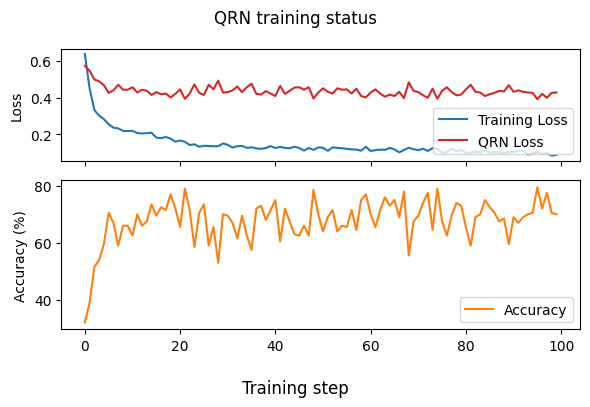

In [10]:
# Plot loss & accuracy
fig, (loss, ac) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [0.75, 1]}, figsize=(6,4))
fig.suptitle('QRN training status')
fig.supxlabel('Training step')

loss.plot(range(len(loss_list)), loss_list, label="Training Loss")
loss.plot(range(len(global_loss_list)), global_loss_list, label="QRN Loss", color="C3")
loss.legend()
loss.set(ylabel='Loss')

ac.plot(range(len(acc_list)), acc_list, label="Accuracy", color="C1")
ac.set(ylabel='Accuracy (%)')
ac.legend()
fig.tight_layout();

In [11]:
extract.eval()
correct = 0
for _, (data, label_batch) in enumerate(test_loader):
        # Initialize performance
        output = torch.zeros(batch_size, n_classes)
        one_hot_target = torch.zeros(batch_size, n_classes)
        for i, label in enumerate(label_batch):
            one_hot_target[i, label] = 1
        one_hot_target = one_hot_target.to(device)

        # Doesn't support batch operation with different weight
        feature_tests = extract(data.to(device))

        for idx in range(batch_size):
          # Initialize performance for this sample
          single_output = torch.zeros(n_classes)
          for _ , (image, label) in enumerate(sup_loader):
              feature_sup = extract(image.to(device))
              features = torch.cat((feature_sup, feature_tests[idx,:].unsqueeze(0)), dim=1)
              value = QRN.forward(features)
              single_output[label] = value[0, 0]

          output[idx] = single_output

        # Calculate & Record
        pred = torch.argmax(output, dim=1)
        label_batch = label_batch.to(device)
        correct += (pred == label_batch).sum().item()

print("Accuracy to Test set: {:.2f}%".format(100 * correct / (n_test * n_classes)))

Accuracy to Test set: 44.50%
